In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import itertools
from time import time
import fasttext
from sklearn import preprocessing
from keras.utils import np_utils
from keras.layers import Dense, Embedding, Input
from keras.layers import Dropout, MaxPooling1D, Conv1D, Conv2D, Flatten, LSTM, Softmax
from keras.models import Model
from keras.preprocessing import text, sequence
from nn_utils import TrainingHistory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import tensorflow as tf
from datetime import timedelta
from tensorflow.python.layers import base
import tensorflow.contrib.slim as slim
import keras.backend as K
import keras

Using TensorFlow backend.


In [3]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
print(str(list_dir))
nbs = []
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
    nbs.append(len(files))
print(str(nbs))
x = np.array(x)
y = np.array(y)

['Advertisement', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
[230, 599, 431, 567, 620, 188, 201, 265, 120, 261]


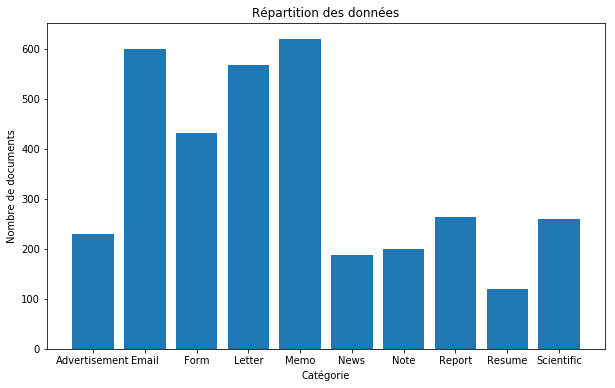

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Répartition des données")
y_pos = np.arange(len(list_dir))
plt.bar(list_dir, nbs, align='center')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de documents')
plt.savefig('repartition_donnees.png')
plt.show()

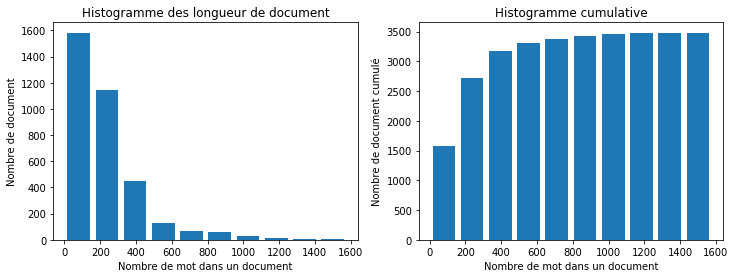

In [32]:
lens = []
for i in range(x.shape[0]):
    line = x[i].replace('\n', ' ').split()
    lens.append(len(line))
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Histogramme des longueur de document')
plt.hist(lens, bins=10, rwidth=0.8)
plt.xlabel('Nombre de mot dans un document')
plt.ylabel('Nombre de document')
plt.subplot(122)
plt.title('Histogramme cumulative')
plt.hist(lens, rwidth=0.8, cumulative=True)
plt.xlabel('Nombre de mot dans un document')
plt.ylabel('Nombre de document cumulé')
plt.savefig('longueue_doc.png')
plt.show()

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [12]:
for i in range(x.shape[0]):
    x[i] = x[i].replace('\n', ' ')
with open('tobacco_nolabel.txt', 'w') as f:
    for i in x:
        f.write(i + '\n')

In [5]:
with open('tobacco_train.txt', 'w') as f:
    for i in range(x_train.shape[0]):
        line = x_train[i] + ' __label__' + y_train[i] + '\n'
        f.write(line)
with open('tobacco_test.txt', 'w') as f:
    for i in range(x_test.shape[0]):
        line = x_test[i] + ' __label__' + y_test[i] + '\n'
        f.write(line)

In [6]:
y[300]

'Memo'

In [7]:
x[300]

'SLevrillard  MEMORANDUM September 24, 1993 TO: W. R. Deaton FROM: E. F. DeLaura RE: Panel Results: Harley Lights 100 MM R&D #1385-6/93  Attached are the Low Tar panel results for The Harley Lights V 1OOMM proto.  Results for the previously reported Harley Lights V 85 MM and the Regular brand are also shown as a source of  reference.  Just to note, the Regular brand testing in which these Low Tar NM panel members tested their own brand blinded, will serve as benchmark data in this and subsequent/panel memos.  The Regular brand results represent the "ideal ratings" as most respondents were extremely favorable in their  evaluations for their regular brand (in test).  Product Specs are as follows:  Harley Lts. 100 MM 9.8 mgs. tar -71 mgs. nic. Harley Lts. 85 MM 8.5 mgs. tar .66 mgs. nic. Conclusions  The Harley Lts. 100 MM proto (1385-6-93) attained an average acceptance of 6.5 among total respondents. While the product scored well among 100 MM and smokers 30 years of age and over, it net

In [33]:
true_labels = []
pred_labels = []
texts = []
clf = fasttext.supervised('tobacco_train.txt', 'model', epoch=100)
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
pred_labels = [e[0] for e in clf.predict(texts)]


In [48]:
import fastText
train_data = 'tobacco_train.txt'
valid_data = 'tobacco_test.txt'
model = fastText.train_supervised(input=train_data,
                                  epoch=100, 
                                  lr=1.0,
                                  wordNgrams=2,
                                  verbose=2,
                                  minCount=1)
model.test(valid_data)
pred = model.predict(valid_data)

In [49]:
true_labels = []
pred_labels = []
texts = []
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
        pred_labels.append(model.predict(spli[0])[0][0].split('__')[-1])

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


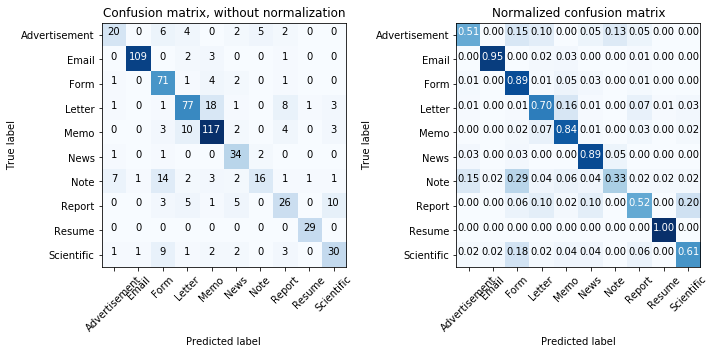

Test Accuracy: 0.7589670014347202


In [51]:
class_names = np.unique(true_labels)
conf_mat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')
plt.show()
print("Test Accuracy:", accuracy_score(true_labels, pred_labels))

# Train word vectors with FastText Skipgram

In [107]:
tic = time()
model_skipgram = fasttext.skipgram('tobacco_nolabel.txt', 
                                   'ft_skipgram_100',
                                   min_count=3,
                                   dim=100,
                                   epoch=50,
                                   thread=16)
toc = time()
print(toc - tic)

38.538986682891846


# Neural network model for text classification

In [4]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of test examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index


def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix


def train_fit_predict(model, x_train, x_test, y_train, history):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


def plot_conf_mat(y_test, y_predicted):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [5]:
def evaluation(vectors_file_path, print_sum=True, plot_mat=True):
    embedding_index = get_embedding_index(vectors_file_path)
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    print('Building model...')
    model = get_model(embedding_matrix, word_index, print_sum=print_sum)
    history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)
    if plot_mat:
        plot_conf_mat(y_test, y_predicted)
    print("Test Accuracy:", accuracy_score(y_test, y_predicted))
    return accuracy_score(y_test, y_predicted)

In [6]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
vectors_file_path = 'ft_skipgram_100.vec'
with open('ft_skipgram_100.vec') as f:
    first_line = f.readline().split()

In [7]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 80
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

In [43]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, y_train, y_test)

Label categories: ['Advertisement' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report'
 'Resume' 'Scientific']
Converting data to trainable form...
Number of training examples: 2785
Number of test examples: 697


In [247]:
len(word_index)

74585

In [132]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    
    #model = Dropout(0.5)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Flatten()(model)
    model = LSTM(128, dropout=0.5, recurrent_dropout=0.5)(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 500, 100)          7571000   
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 500, 64)           19264     
_________________________________________________________________
dropout_120 (Dropout)        (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 250, 64)           0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 250, 64)           12352     
_____________________________________________

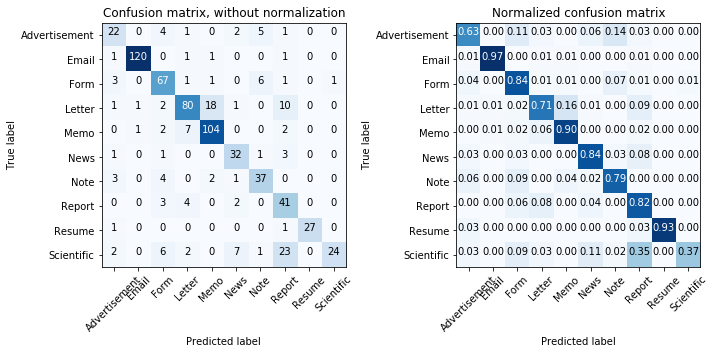

Test Accuracy: 0.7948350071736011


0.7948350071736011

In [133]:
evaluation(vectors_file_path, print_sum=True, plot_mat=True)

In [98]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

Found 155801 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 200, 100)          7375100   
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 200, 64)           19264     
_________________________________________________________________
dropout_96 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 100, 64)           0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 100, 64)           12352     
____________________________________________

2506/2506 [==============================] - 0s 61us/step - loss: 0.1621 - acc: 0.9413 - val_loss: 0.9052 - val_acc: 0.6774
Epoch 47/50
2506/2506 [==============================] - 0s 61us/step - loss: 0.2082 - acc: 0.9278 - val_loss: 0.8838 - val_acc: 0.6846
Epoch 48/50
2506/2506 [==============================] - 0s 61us/step - loss: 0.1699 - acc: 0.9457 - val_loss: 0.8688 - val_acc: 0.6846
Epoch 49/50
2506/2506 [==============================] - 0s 62us/step - loss: 0.1485 - acc: 0.9537 - val_loss: 0.8641 - val_acc: 0.7025
Epoch 50/50
2506/2506 [==============================] - 0s 61us/step - loss: 0.1353 - acc: 0.9517 - val_loss: 0.9286 - val_acc: 0.7061
Confusion matrix, without normalization
Normalized confusion matrix


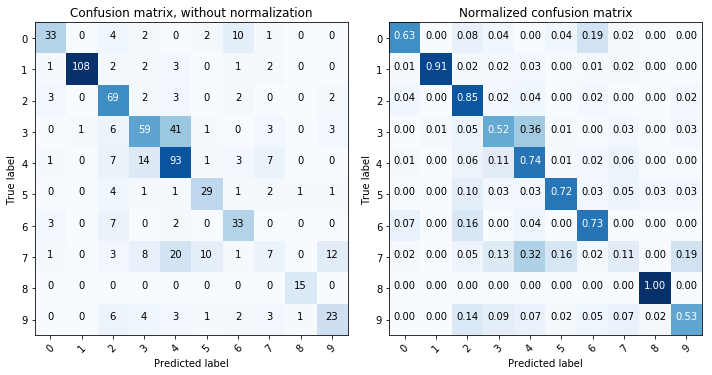

Test Accuracy: 0.672883787661406


0.672883787661406

In [99]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    #model = Dropout(0.5)(model)
    #model = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    #model = LSTM(128, dropout=0.5, recurrent_dropout=0.3)(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# TF-IDF

In [27]:
TF_IDF_FEATURES = 2000

x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create document vectors
vectorizer = CountVectorizer(max_features=TF_IDF_FEATURES)
vectorizer.fit(x_train)
x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

# With TF-IDF representation
tf_transformer = TfidfTransformer()
tfidf = tf_transformer.fit(x_train_counts)
x_train_tf = tfidf.transform(x_train_counts)
x_test_tf = tfidf.transform(x_test_counts)
"""
x_train_tf = x_train_tf.toarray()
x_train_tf = np.reshape(x_train_tf, (x_train_tf.shape[0], x_train_tf.shape[1], 1))
x_test_tf = x_test_tf.toarray()
x_test_tf = np.reshape(x_test_tf, (x_test_tf.shape[0], x_test_tf.shape[1], 1))
"""

'\nx_train_tf = x_train_tf.toarray()\nx_train_tf = np.reshape(x_train_tf, (x_train_tf.shape[0], x_train_tf.shape[1], 1))\nx_test_tf = x_test_tf.toarray()\nx_test_tf = np.reshape(x_test_tf, (x_test_tf.shape[0], x_test_tf.shape[1], 1))\n'

# Neural Network with TF-IDF

In [28]:
def get_model():

    inp = Input(shape=(TF_IDF_FEATURES,))
    #model = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(inp)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    #model = Flatten()(model)
    model = Dense(512, activation='relu')(inp)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def preprocess_label(y_train, y_test):
    CLASSES_LIST = np.unique(y_train)
    print('Label categories: ' + str(CLASSES_LIST))
    le = preprocessing.LabelEncoder()
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train) 
    y_test = le.transform(y_test) 
    train_y_cat = np_utils.to_categorical(y_train, NUM_CLASS)
    return train_y_cat, y_train, y_test


def class_str_2_ind_label(y_train, y_test):
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    test_y_cat = np_utils.to_categorical(y_test, n_out)
    
    return y_train, y_test, train_y_cat, test_y_cat


In [29]:
# Model parameters
#MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
#EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 2000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               1024512   
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                5130      
Total params: 1,029,642
Trainable params: 1,029,642
Non-trainable params: 0
_________________________________________________________________
Train on 2506 samples, validate on 279 samples
Epoch 1/20
2506/2506 [==============================] - 1s 322us/step - loss: 2.1558 - acc: 0.3915 - val_loss: 1.9629 - val_acc: 0.4301
Epoch 2/20
2506/2506 [==============================] - 0s 36us/step - loss: 1.69

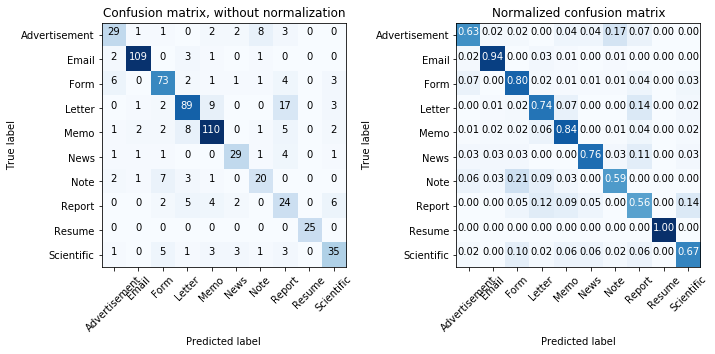

Test Accuracy: 0.7790530846484935


In [30]:
y_train, y_test, train_y_cat, test_y_cat = class_str_2_ind_label(y_train, y_test)
model = get_model()
history = TrainingHistory(x_test_tf, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_train_tf, x_test_tf, train_y_cat, history).argmax(1)
plot_conf_mat(y_test, y_predicted)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))

# Self-attention model

[Code](https://github.com/CyberZHG/keras-self-attention)

In [31]:
x_train_tf = x_train_tf.toarray()
x_train_tf = np.reshape(x_train_tf, (x_train_tf.shape[0], x_train_tf.shape[1], 1))
x_test_tf = x_test_tf.toarray()
x_test_tf = np.reshape(x_test_tf, (x_test_tf.shape[0], x_test_tf.shape[1], 1))

In [13]:
class ScaledDotProductAttention(keras.layers.Layer):
    
    def __init__(self,
                 **kwargs):
        """Initialize the layer.
        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        #self.supports_masking = True
        #self.return_attention = return_attention
        #self.history_only = history_only
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        
    def call(self, inputs, mask=None, **kwargs):
        query = inputs
        key = inputs
        value = inputs
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2)# / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        """
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            ones = tf.ones((query_len, key_len))
            e -= (ones - tf.matrix_band_part(ones, -1, 0)) * 1e9
        if isinstance(mask, list) and mask[-1] is not None:
            e -= (1.0 - K.cast(K.expand_dims(mask[-1], axis=-2), K.floatx())) * 1e9
        """
        a = keras.activations.softmax(e)
        v = K.batch_dot(a, value)
        #v = K.squeeze(v, axis=2)
        #if self.return_attention:
        #    return [v, a]
        print(v.shape)
        return v


In [37]:
def get_model():

    inp = Input(shape=(TF_IDF_FEATURES,1))
    model = ScaledDotProductAttention()(inp)
    #model = Flatten()(model)
    model = Dense(TF_IDF_FEATURES, activation='relu', input_shape=(TF_IDF_FEATURES,))(model)
    model = Dropout(0)(model)
    model = Dense(128, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Flatten()(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


In [38]:
# Model parameters
#MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
#EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

(?, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 2000, 1)           0         
_________________________________________________________________
scaled_dot_product_attention (None, 2000, 1)           0         
_________________________________________________________________
dense_32 (Dense)             (None, 2000, 2000)        4000      
_________________________________________________________________
dropout_20 (Dropout)         (None, 2000, 2000)        0         
_________________________________________________________________
dense_33 (Dense)             (None, 2000, 128)         256128    
_________________________________________________________________
dropout_21 (Dropout)         (None, 2000, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256000)            0       

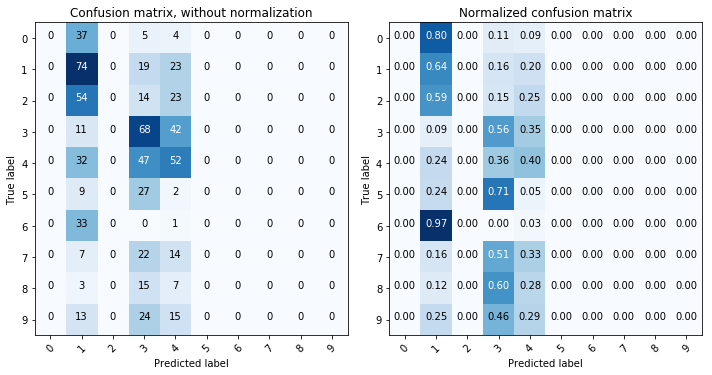

Test Accuracy: 0.2783357245337159


In [39]:
y_train, y_test, train_y_cat, test_y_cat = class_str_2_ind_label(y_train, y_test)
model = get_model()
history = TrainingHistory(x_test_tf, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_train_tf, x_test_tf, train_y_cat, history).argmax(1)
plot_conf_mat(y_test, y_predicted)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))

# Self-attention with embedding

In [25]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
vectors_file_path = 'ft_skipgram_100.vec'
with open(vectors_file_path) as f:
    first_line = f.readline().split()

In [29]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 100
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

Converting data to trainable form...
Number of training examples: 3133
Number of test examples: 349
Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
(?, 200, 100)
(?, 200, 64)
(?, 200, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 200, 100)          8178700   
_________________________________________________________________
scaled_dot_product_attention (None, 200, 100)          0         
_________________________________________________________________
dense_44 (Dense)             (None, 200, 64)           6464      
_________________________________________________________________
dropout_28 (Dropout)         (None, 200, 64)           0         
_____________________________________

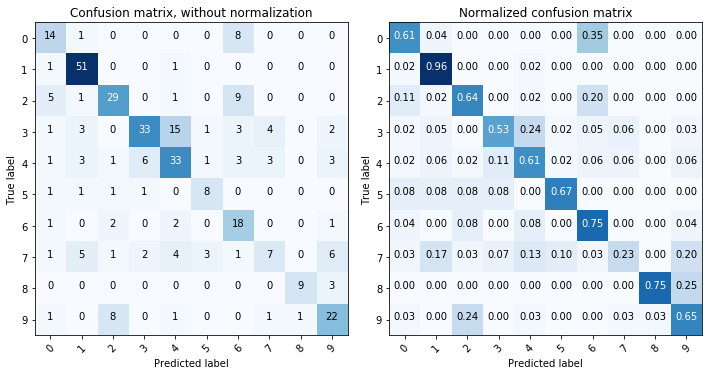

Test Accuracy: 0.6418338108882522


0.6418338108882522

In [31]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    model = ScaledDotProductAttention()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = ScaledDotProductAttention()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = ScaledDotProductAttention()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Flatten()(model)
    
    #model = Dense(128, activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, y_train, y_test)
evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# Tensorflow NN version with self-attention 

In [19]:
class TextCNN(object):
    """Text Classification, CNN Model"""
    
    def __init__(self, config):
        self.config = config
        # inputs
        self.input_x = tf.placeholder(tf.float32,
                                      [None, self.config.tf_idf_features], 
                                      name='input_x')
        self.input_y = tf.placeholder(tf.float32,
                                      [None, self.config.num_classes],
                                      name='input_y')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        self.self_attention()
        slim.model_analyzer.analyze_vars(tf.trainable_variables(), print_info=True)
    
    def self_attention(self):
        """Self Attention Model"""
        with tf.name_scope("self_attention"):
            # inputs shape : [batch, tf_idf_features]
            
            # self_attention layer
            self_att = tf.matmul(self.input_x, self.input_x, transpose_b=True)
            self_att = tf.nn.softmax(self_att)
            self_att = tf.matmul(self_att, self.input_x)
            fc = tf.layers.dense(self_att, units=512, activation=tf.nn.relu, name='fc1')
            fc_dropout = tf.contrib.layers.dropout(fc, keep_prob=self.keep_prob)
            self_att = tf.matmul(fc_dropout, fc_dropout, transpose_b=True)
            self_att = tf.nn.softmax(self_att)
            self_att = tf.matmul(self_att, fc_dropout)
            fc = tf.layers.dense(self_att, units=512, activation=tf.nn.relu, name='fc2')
            fc_dropout = tf.contrib.layers.dropout(fc, keep_prob=self.keep_prob)
        
        with tf.name_scope("score"):
            self.logits = tf.layers.dense(fc_dropout, units=self.config.num_classes, name='fc3')
            self.y_pred_cls = tf.argmax(tf.nn.softmax(self.logits), 1)

        with tf.name_scope("optimize"):
            # loss function, cross entropy
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                    labels=self.input_y)
            self.loss = tf.reduce_mean(cross_entropy)
            # opptimizer
            self.optim = tf.train.AdamOptimizer(learning_rate=self.config.learning_rate).minimize(self.loss)
        
        
        with tf.name_scope("accuracy"):
            # accuracy
            correct_pred = tf.equal(tf.argmax(self.input_y, 1), self.y_pred_cls)
            self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Run self-attention model

In [20]:
tf.reset_default_graph()

def get_time_diff(start_time):
    """get time passed"""
    end_time = time()
    time_diff = end_time - start_time
    return timedelta(seconds=int(round(time_diff)))


def batch_iter(x, y, batch_size=128):
    """generate batch data"""
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) 
    if (data_len - 1) % batch_size != 0:
        num_batch = num_batch + 1
    
    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]
    
    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]
        
def feed_data(model, x_batch, y_batch, keep_prob):
    feed_dict = {
        model.input_x: x_batch,
        model.input_y: y_batch,
        model.keep_prob: keep_prob
    }
    return feed_dict

def evaluate(model, sess, x_, y_):
    """evaluate the accuracy and loss on an example"""
    data_len = len(x_)
    batch_eval = batch_iter(x_, y_, 128)
    total_loss = 0.0
    total_acc = 0.0
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        feed_dict = feed_data(model, x_batch, y_batch, 1.0)
        loss, acc = sess.run([model.loss, model.acc], feed_dict=feed_dict)
        total_loss += loss * batch_len
        total_acc += acc * batch_len

    return total_loss / data_len, total_acc / data_len

def train(model, x_train, y_train, config):
    """
    print("Configuring TensorBoard and Saver...")
    # config Tensorboard，delete tensorboard folder for re-training
    tensorboard_dir = 'tensorboard/textcnn'
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)
    
    tf.summary.scalar("loss", model.loss)
    tf.summary.scalar("accuracy", model.acc)
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(tensorboard_dir)
    
    # config saver
    saver = tf.train.Saver()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    print("Loading training and validation data...")
    start_time = time.time()
    x, y = process_datasets(train_dir, cat_to_id,
                            max_length=config.seq_length,
                            vocab_size=config.vocab_size)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1)
    time_diff = get_time_diff(start_time)
    print("Time usage:", time_diff)
    """
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
    # Create session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #writer.add_graph(session.graph

        print("Training and evaluating...")
        start_time = time()
        total_batch = 0 # total batch
        best_acc_val = 0.0 # best validation set accurary
        last_improved = 0 # record last improved batch
        # if more than 1000 batches, we don't get improvement, we terminate training phase
        require_improvement = 1000
        
        flag = False
        for epoch in range(config.num_epochs):
            print("Epoch:", epoch + 1)
            batch_train = batch_iter(x_train, y_train, config.batch_size)
            for x_batch, y_batch in batch_train:
                        
                feed_dict = feed_data(model, x_batch, y_batch, config.dropout_keep_prob)
                
                #if total_batch % config.save_per_batch == 0:
                #    s = sess.run(merged_summary, feed_dict=feed_dict)
                #    writer.add_summary(s, total_batch)
                """    
                feed_dict = {
                    model.input_x: x_batch,
                    model.input_y: y_batch,
                    model.keep_prob: config.dropout_keep_prob
                }
                """
                if total_batch % config.print_per_batch == 0:
                    feed_dict[model.keep_prob] = 1.0
                    loss_train, acc_train = sess.run([model.loss, model.acc],
                                                     feed_dict=feed_dict)
                    loss_val, acc_val = evaluate(model, sess, x_val, y_val)
                    
                    if acc_val > best_acc_val:
                        # Save the best result
                        best_acc_val = acc_val
                        last_improved = total_batch
                        #saver.save(sess=sess, save_path=save_path)
                        improved_str = '*'
                    else:
                        improved_str = ''
                        
                    time_diff = get_time_diff(start_time)
                    msg = 'Iter: {0:>6}, Train Loss: {1:>6.2}, Train Acc: {2:>7.2%},' \
                      + ' Val Loss: {3:>6.2}, Val Acc: {4:>7.2%}, Time: {5} {6}'
                    print(msg.format(total_batch, loss_train, acc_train, loss_val,
                                     acc_val, time_diff, improved_str))
                    
                sess.run(model.optim, feed_dict=feed_dict) # run optimization
                total_batch += 1
                
                if total_batch - last_improved > require_improvement:
                    print("No optimization for a long time, auto-stopping...")
                    flag = True
                    break
            if flag:
                break
                
def test(model, x_test, y_test, config):
    print("Loading test data...")
    start_time = time()
    #x_test, y_test = process_datasets(test_dir, cat_to_id, conf)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver = tf.train.Saver()
        #saver.restore(sess=sess, save_path=save_path)
        
        print("Testing...")
        loss_test, acc_test = evaluate(model, sess, x_test, y_test)
        msg = 'Test Loss: {0:>6.2}, Test Acc: {1:>7.2%}'
        print(msg.format(loss_test, acc_test))
        
        batch_size = config.batch_size
        data_len = len(x_test)
        num_batch = (data_len - 1) / batch_size
        if (data_len - 1) % batch_size != 0:
            num_batch += 1
        
        y_test_cls = np.argmax(y_test, 1)
        y_pred_cls = np.zeros(shape=len(x_test), dtype=np.int32)
        for i in range(num_batch):
            start_id = i * batch_size
            end_id = ((i + 1) * batch_size, data_len)
            elmo_context_input_ = sess.run(
                    [elmo_context_input['weighted_op']],
                    feed_dict={context_token_ids: x_test[start_id:end_id]}
                )
            feed_dict = {
                model.input_x: elmo_context_input,
                model.keep_prob: 1.0
            }
            y_pred_cls[start_id:end_id] = sess.run(model.y_pred_cls, feed_dict=feed_dict)
        
        print("Precision, Recall and F1-Score...")
        print(metrics.classification_report(y_test_cls, y_pred_cls, target_names=categories))
        
        #print("Confusion Matrix...")
        #cm = metrics.confusion_matrix(y_test_cls, y_pred_cls)
        plot_conf_mat(y_test, y_predicted)
        print("Test Accuracy:", accuracy_score(y_test, y_predicted))
        
        time_diff = get_time_diff(start_time)
        print("Time usage: ", time_diff)


In [21]:
def run_self_attention():
    #if argv not in ['train', 'test']:
    #    raise ValueError("Wrong argument.")
        
    #print("Configuring CNN Model...")
    config = TCNNConfig()
    #words, word_to_id = read_vocab(vocab_dir)
    #config.vocab_size = len(words)
    model = TextCNN(config)
    
    #if argv == 'train':
    train(model, x_train_tf.toarray(), train_y_cat, config)
    #else:
    
    train(model, x_test_tf.toarray(), test_y_cat, config)

In [22]:
class TCNNConfig(object):
    """CNN parrameters config"""
    embedding_dim = 600  # embedding_size
    seq_length = 2000  # max length for each news
    tf_idf_features = 4000
    num_classes = NUM_CLASS  
    num_filters = 32  # number of filters
    kernel_size = 5  # conv kernel size
    vocab_size = 185734

    hidden_dim = 512  # number of units in fc1
    
    dropout_keep_prob = 0.5 
    learning_rate = 1e-3

    batch_size = 128  
    num_epochs = 20  

    print_per_batch = 100  
    save_per_batch = 10  # save into tensorboard

run_self_attention()

---------
Variables: name (type shape) [size]
---------
fc1/kernel:0 (float32_ref 4000x512) [2048000, bytes: 8192000]
fc1/bias:0 (float32_ref 512) [512, bytes: 2048]
fc2/kernel:0 (float32_ref 512x512) [262144, bytes: 1048576]
fc2/bias:0 (float32_ref 512) [512, bytes: 2048]
fc3/kernel:0 (float32_ref 512x10) [5120, bytes: 20480]
fc3/bias:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 2316298
Total bytes of variables: 9265192
Training and evaluating...
Epoch: 1
Iter:      0, Train Loss:    2.3, Train Acc:   5.47%, Val Loss:    2.3, Val Acc:   5.38%, Time: 0:00:00 *
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Iter:    100, Train Loss:    2.2, Train Acc:  19.53%, Val Loss:    2.1, Val Acc:  16.49%, Time: 0:00:01 *
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Iter:    200, Train Loss:    2.2, Train Acc:  13.28%, Val Loss:    2.1, Val Acc:  16.49%, Time: 0:00:01 
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Iter:    300, Train Loss:    2.2, Train Acc:  14.06%, Val Loss:  